<a href="https://colab.research.google.com/github/syenirasheila/Predicting-The-Magnitude-And-Location-Of-Earthquakes-In-Indonesia/blob/main/Analysis_and_Prediction_of_Earthquake_Locations_Indonesia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediksi Lokasi Gempa Bumi Indonesia Menggunakan Prophet Forecasting


##Pengumpulan Data

In [ ]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import library package

import gc
from tqdm import tqdm
import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot
import seaborn as sns
import datetime as dt
from datetime import date
from datetime import timedelta
from prophet import Prophet

%matplotlib inline
import os
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#koneksi google drive
from google.colab import drive

drive.mount("/content/MyDrive")

Mounted at /content/MyDrive


In [ ]:
data0=pd.read_csv('/content/MyDrive/MyDrive/DS_118/Data_Gempa_Indonesia/katalog_gempa.csv')
data0[1:2]

,tgl,ot,lat,lon,depth,mag,remark,strike1,dip1,rake1,strike2,dip2,rake2
1,2008/11/01,20:58:50.248,-6.55,129.64,10,4.6,Banda Sea,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#cek row dan column
data0.shape

(92887, 13)

In [ ]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92887 entries, 0 to 92886
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tgl      92887 non-null  object 
 1   ot       92887 non-null  object 
 2   lat      92887 non-null  float64
 3   lon      92887 non-null  float64
 4   depth    92887 non-null  int64  
 5   mag      92887 non-null  float64
 6   remark   92887 non-null  object 
 7   strike1  2735 non-null   float64
 8   dip1     2735 non-null   float64
 9   rake1    2735 non-null   float64
 10  strike2  2735 non-null   float64
 11  dip2     2735 non-null   float64
 12  rake2    2735 non-null   float64
dtypes: float64(9), int64(1), object(3)
memory usage: 9.2+ MB


##EDA

In [ ]:
#cek data yang kosong
data0.isnull().sum()

tgl            0
ot             0
lat            0
lon            0
depth          0
mag            0
remark         0
strike1    90152
dip1       90152
rake1      90152
strike2    90152
dip2       90152
rake2      90152
dtype: int64

In [ ]:
#cek duplikasi data
print(data0.duplicated().value_counts())

False    92887
dtype: int64


In [ ]:
#cek panjang objek data tanggal
lengths = data0["tgl"].str.len()
lengths.value_counts()

10    92887
Name: tgl, dtype: int64

In [ ]:
#cek panjang objek data waktu
lengths = data0["ot"].str.len()
lengths.value_counts()

12    92887
Name: ot, dtype: int64

In [ ]:
#drop fitur
data0=data0.fillna('N')
data1=data0[['ot','tgl','lat','lon','depth', 'mag','remark']]
data1[0:5]

,ot,tgl,lat,lon,depth,mag,remark
0,21:02:43.058,2008/11/01,-9.18,119.06,10,4.9,Sumba Region - Indonesia
1,20:58:50.248,2008/11/01,-6.55,129.64,10,4.6,Banda Sea
2,17:43:12.941,2008/11/01,-7.01,106.63,121,3.7,Java - Indonesia
3,16:24:14.755,2008/11/01,-3.30,127.85,10,3.2,Seram - Indonesia
4,16:20:37.327,2008/11/01,-6.41,129.54,70,4.3,Banda Sea


In [ ]:
#mengubah nama kolom
data1.rename(columns = {'ot':'waktu_gempa', 'lat':'garis_lintang',
                     'lon':'garis_bujur', 'depth':'kedalaman_gempa',
                     'mag':'kekuatan_gempa', 'remark':'lokasi_gempa'}, inplace = True)
data1.columns

Index(['waktu_gempa', 'tgl', 'garis_lintang', 'garis_bujur', 'kedalaman_gempa',
       'kekuatan_gempa', 'lokasi_gempa'],
      dtype='object')

In [ ]:
data1

,waktu_gempa,tgl,garis_lintang,garis_bujur,kedalaman_gempa,kekuatan_gempa,lokasi_gempa
0,21:02:43.058,2008/11/01,-9.18,119.06,10,4.9,Sumba Region - Indonesia
1,20:58:50.248,2008/11/01,-6.55,129.64,10,4.6,Banda Sea
2,17:43:12.941,2008/11/01,-7.01,106.63,121,3.7,Java - Indonesia
3,16:24:14.755,2008/11/01,-3.30,127.85,10,3.2,Seram - Indonesia
4,16:20:37.327,2008/11/01,-6.41,129.54,70,4.3,Banda Sea
...,...,...,...,...,...,...,...
92882,02:25:09.288,2023/01/26,3.24,127.18,10,4.0,Talaud Islands - Indonesia
92883,02:15:03.893,2023/01/26,2.70,127.10,10,3.9,Northern Molucca Sea
92884,01:57:08.885,2023/01/26,-7.83,121.07,10,3.8,Flores Sea
92885,01:46:21.009,2023/01/26,3.00,127.16,10,4.1,Northern Molucca Sea


In [ ]:
#kekuatan gempa indonesia tahun 2008 hingga 2023
import plotly.express as px
fig=px.scatter(x=data1['tgl'],y=data1['kekuatan_gempa'])
fig=px.scatter(data1, x="tgl", y="kekuatan_gempa")
fig.update_layout(title='Kekuatan Gempa di Indonesia Tahun 2008-2023')
fig.show()

In [ ]:
#menggabungkan garis lintang dan garis bujur serta membuat lokasi berdasarkan garis tsb
import itertools
from itertools import product

lat=list(range(-11*10,6*10+1))  # -11-6
long=list(range(94*10,142*10+1))   # 94-142

LL=list(itertools.product(lat,long))
LLdf=pd.DataFrame(LL)
LLdf=LLdf/10                   ######

for i in range(len(LLdf)):
    LLdf.loc[i,'LL']=str([LLdf.iloc[i,0],(LLdf.iloc[i,1])])

LLdf[3]=list(range(len(LLdf)))
LLdf.columns=['garis_lintang','garis_bujur','LL','lokasi_gempa']
LLdf

,garis_lintang,garis_bujur,LL,lokasi_gempa
0,-11.0,94.0,"[-11.0, 94.0]",0
1,-11.0,94.1,"[-11.0, 94.1]",1
2,-11.0,94.2,"[-11.0, 94.2]",2
3,-11.0,94.3,"[-11.0, 94.3]",3
4,-11.0,94.4,"[-11.0, 94.4]",4
...,...,...,...,...
82246,6.0,141.6,"[6.0, 141.6]",82246
82247,6.0,141.7,"[6.0, 141.7]",82247
82248,6.0,141.8,"[6.0, 141.8]",82248
82249,6.0,141.9,"[6.0, 141.9]",82249


In [ ]:
Name=LLdf['LL'].tolist()
N=LLdf['lokasi_gempa'].tolist()
normal_mapping=dict(zip(Name,N))
reverse_mapping=dict(zip(N,Name))
print(max(N))

82250


In [ ]:
data1['garis_lintang2']=data1['garis_lintang'].round(1)
data1['garis_bujur2']=data1['garis_bujur'].round(1)
lokasi_gempa=[]
for a,b in zip(data1['garis_lintang2'],data1['garis_bujur2']):
    lokasi_gempa+=[[a,b]]
data1['LL']=lokasi_gempa
data1['LL']=data1['LL'].astype(str)
data1['lokasi_gempa']=data1['LL'].map(normal_mapping)
data1

,waktu_gempa,tgl,garis_lintang,garis_bujur,kedalaman_gempa,kekuatan_gempa,lokasi_gempa,garis_lintang2,garis_bujur2,LL
0,21:02:43.058,2008/11/01,-9.18,119.06,10,4.9,8909.0,-9.2,119.1,"[-9.2, 119.1]"
1,20:58:50.248,2008/11/01,-6.55,129.64,10,4.6,21520.0,-6.6,129.6,"[-6.6, 129.6]"
2,17:43:12.941,2008/11/01,-7.01,106.63,121,3.7,19366.0,-7.0,106.6,"[-7.0, 106.6]"
3,16:24:14.755,2008/11/01,-3.30,127.85,10,3.2,37375.0,-3.3,127.8,"[-3.3, 127.8]"
4,16:20:37.327,2008/11/01,-6.41,129.54,70,4.3,22481.0,-6.4,129.5,"[-6.4, 129.5]"
...,...,...,...,...,...,...,...,...,...,...
92882,02:25:09.288,2023/01/26,3.24,127.18,10,4.0,68634.0,3.2,127.2,"[3.2, 127.2]"
92883,02:15:03.893,2023/01/26,2.70,127.10,10,3.9,66228.0,2.7,127.1,"[2.7, 127.1]"
92884,01:57:08.885,2023/01/26,-7.83,121.07,10,3.8,15663.0,-7.8,121.1,"[-7.8, 121.1]"
92885,01:46:21.009,2023/01/26,3.00,127.16,10,4.1,67672.0,3.0,127.2,"[3.0, 127.2]"


In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92887 entries, 0 to 92886
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   waktu_gempa      92887 non-null  object 
 1   tgl              92887 non-null  object 
 2   garis_lintang    92887 non-null  float64
 3   garis_bujur      92887 non-null  float64
 4   kedalaman_gempa  92887 non-null  int64  
 5   kekuatan_gempa   92887 non-null  float64
 6   lokasi_gempa     92279 non-null  float64
 7   garis_lintang2   92887 non-null  float64
 8   garis_bujur2     92887 non-null  float64
 9   LL               92887 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 7.1+ MB


In [ ]:
data1['lokasi_gempa'].max()

82160.0

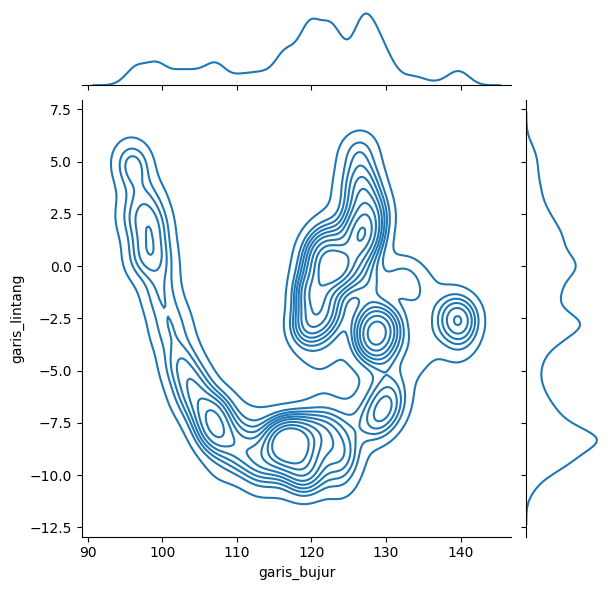

In [ ]:
sns.jointplot(data=data1, x='garis_bujur', y='garis_lintang', kind="kde")
plt.show()

In [ ]:
#lokasi dengan kekuatan gempa lebih dari 4.7 SR
data2=data1[['tgl','lokasi_gempa']][data1['kekuatan_gempa']>4.7].reset_index(drop=True)
data2[0:10]

,tgl,lokasi_gempa
0,2008/11/01,8909.0
1,2008/11/01,19116.0
2,2008/11/01,21518.0
3,2008/11/03,49393.0
4,2008/11/03,58234.0
5,2008/11/04,34712.0
6,2008/11/06,41424.0
7,2008/11/07,20556.0
8,2008/11/07,18618.0
9,2008/11/07,75357.0


In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8818 entries, 0 to 8817
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tgl           8818 non-null   object 
 1   lokasi_gempa  8774 non-null   float64
dtypes: float64(1), object(1)
memory usage: 137.9+ KB


In [ ]:
data3=data2.sort_values('tgl').reset_index(drop=True)
data3[0:10]

,tgl,lokasi_gempa
0,2008/11/01,8909.0
1,2008/11/01,19116.0
2,2008/11/01,21518.0
3,2008/11/03,49393.0
4,2008/11/03,58234.0
5,2008/11/04,34712.0
6,2008/11/06,41424.0
7,2008/11/07,20556.0
8,2008/11/07,18618.0
9,2008/11/07,75357.0


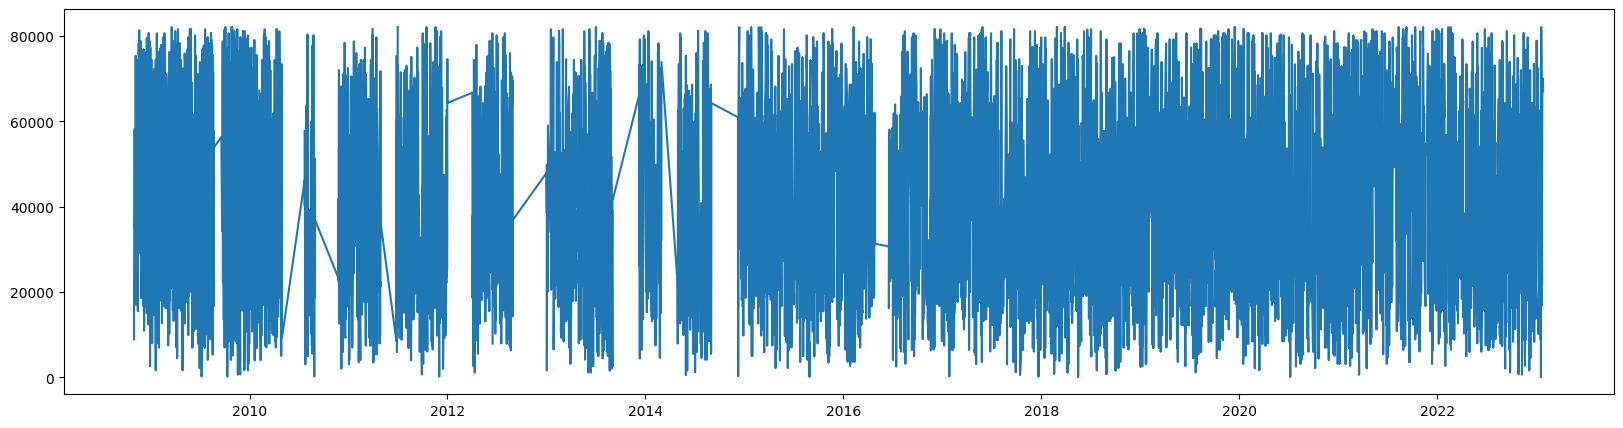

In [ ]:
item1=data3

item1.columns = ['ds','y']
item1.y = item1.y.astype('float')
item1.ds = item1.ds.astype('datetime64')

rcParams['figure.figsize'] = 20,5
plt.plot(item1.ds, item1.y)

##Model Prophet

### Prediksi dan Fit Data Terdahulu

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsh_5jre_/6n23uztz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsh_5jre_/laf09nfw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46716', 'data', 'file=/tmp/tmpsh_5jre_/6n23uztz.json', 'init=/tmp/tmpsh_5jre_/laf09nfw.json', 'output', 'file=/tmp/tmpsh_5jre_/prophet_modelml0vpkyl/prophet_model-20230615073004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:30:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:30:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


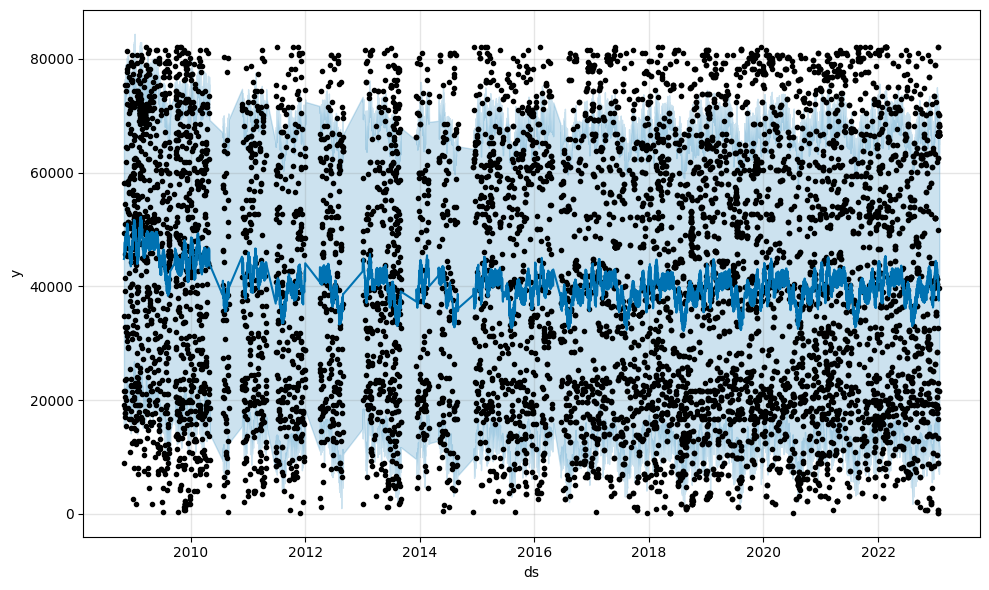

In [ ]:
ph = Prophet()
ph.fit(item1)
forecast1=ph.predict(item1)
figure = ph.plot(forecast1)
figure.show()

In [ ]:
result1=forecast1[['ds','yhat','yhat_lower','yhat_upper']]
result1.tail()

,ds,yhat,yhat_lower,yhat_upper
8813,2023-01-24,38583.443450,12095.148621,68560.045401
8814,2023-01-26,39538.493701,10922.362135,68041.218825
8815,2023-01-26,39538.493701,9067.668131,65908.626471
8816,2023-01-26,39538.493701,11382.840093,69473.480687
8817,2023-01-26,39538.493701,10387.016562,69039.629988


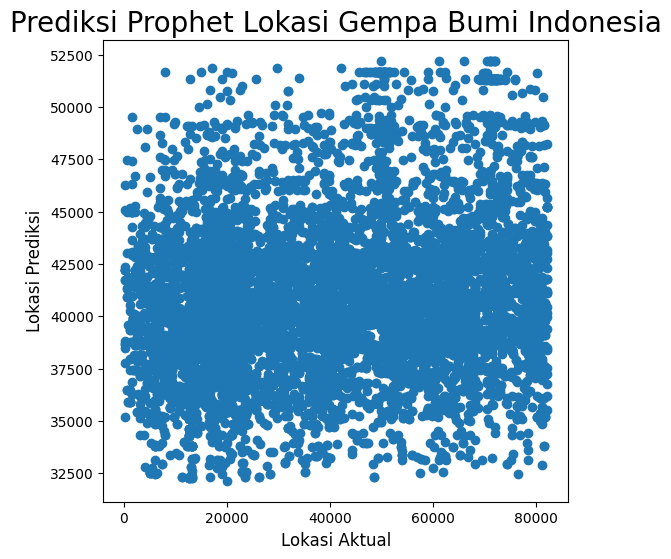

In [ ]:
y=item1['y']           #nilai aktual
oof=result1['yhat']    #nilai prediksi
fig,ax = plt.subplots(figsize=(6,6))
ax.set_title('Prediksi Prophet Lokasi Gempa Bumi Indonesia',fontsize=20)
ax.set_xlabel('Lokasi Aktual',fontsize=12)
ax.set_ylabel('Lokasi Prediksi',fontsize=12)
ax.scatter(y,oof)

### Prediksi Data Terdahulu + Masa Depan dan Fit Data Terdahulu

In [ ]:
from datetime import timedelta
start0 = dt.datetime.strptime('2023-01-27','%Y-%m-%d').date()
end0   = dt.datetime.strptime('2026-12-31','%Y-%m-%d').date()
print((end0-start0).days)

1434


In [ ]:
def daterange(start,end):
    for i in range((end-start).days):
        return start+timedelta(i)

In [ ]:
dates0=[]
for i in range((end0-start0).days):
    dates0+=[(start0+timedelta(i)).strftime('%Y-%m-%d') ]
print(dates0[0:30])

['2023-01-27', '2023-01-28', '2023-01-29', '2023-01-30', '2023-01-31', '2023-02-01', '2023-02-02', '2023-02-03', '2023-02-04', '2023-02-05', '2023-02-06', '2023-02-07', '2023-02-08', '2023-02-09', '2023-02-10', '2023-02-11', '2023-02-12', '2023-02-13', '2023-02-14', '2023-02-15', '2023-02-16', '2023-02-17', '2023-02-18', '2023-02-19', '2023-02-20', '2023-02-21', '2023-02-22', '2023-02-23', '2023-02-24', '2023-02-25']


In [ ]:
dates0_df=pd.DataFrame(dates0)
dates0_df.columns=['ds']
dates0_df

,ds
0,2023-01-27
1,2023-01-28
2,2023-01-29
3,2023-01-30
4,2023-01-31
...,...
1429,2026-12-26
1430,2026-12-27
1431,2026-12-28
1432,2026-12-29


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsh_5jre_/0dc91mat.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsh_5jre_/c1wu7i2w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48629', 'data', 'file=/tmp/tmpsh_5jre_/0dc91mat.json', 'init=/tmp/tmpsh_5jre_/c1wu7i2w.json', 'output', 'file=/tmp/tmpsh_5jre_/prophet_modelfxfpt4vv/prophet_model-20230615073009.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:30:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:30:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


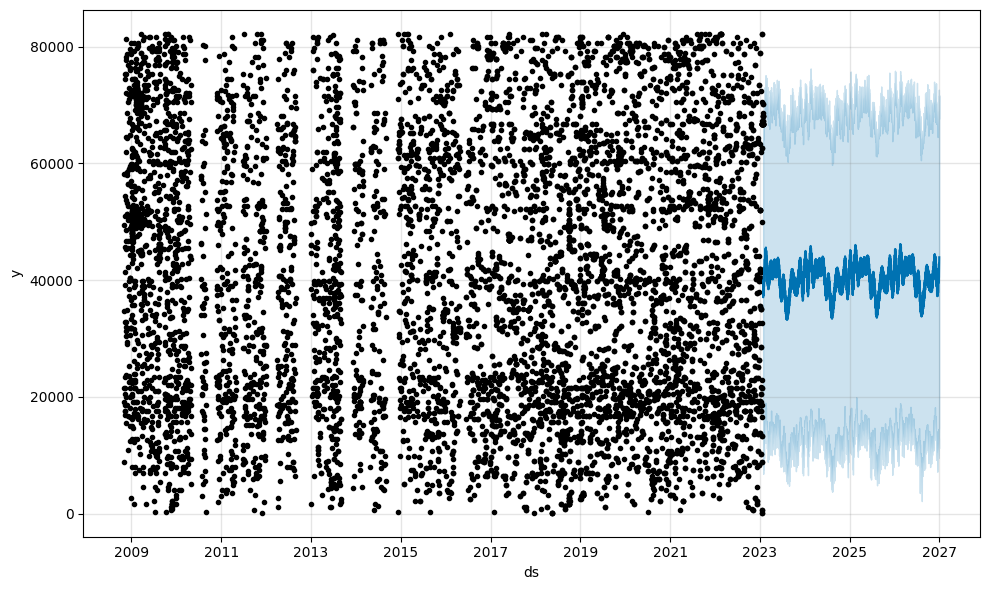

In [ ]:
ph = Prophet()
ph.fit(item1)
forecast3=ph.predict(dates0_df)
figure = ph.plot(forecast3)
figure.show()

In [ ]:
result3=forecast3[['ds','yhat','yhat_lower','yhat_upper']][339:704*2]
result3

,ds,yhat,yhat_lower,yhat_upper
339,2024-01-01,41219.632208,16100.968135,69065.023956
340,2024-01-02,42805.160954,14814.668627,72184.682183
341,2024-01-03,44456.821760,15696.391429,73701.925862
342,2024-01-04,44420.446141,16377.598842,70942.103857
343,2024-01-05,44361.698916,15861.154373,70268.168254
...,...,...,...,...
1403,2026-11-30,41063.564661,12698.995428,70262.944471
1404,2026-12-01,42107.508535,14854.456990,70210.463217
1405,2026-12-02,43233.928810,16154.314928,70624.894891
1406,2026-12-03,42699.173181,14390.104885,72154.236884


In [ ]:
result3['L0']=result3['yhat'].apply(lambda x: int(round(x)))
result3['L1']=result3['L0'].map(reverse_mapping)
result3=result3.reset_index(drop=True)
result3

,ds,yhat,yhat_lower,yhat_upper,L0,L1
0,2024-01-01,41219.632208,16100.968135,69065.023956,41220,"[-2.5, 127.5]"
1,2024-01-02,42805.160954,14814.668627,72184.682183,42805,"[-2.2, 141.7]"
2,2024-01-03,44456.821760,15696.391429,73701.925862,44457,"[-1.8, 114.5]"
3,2024-01-04,44420.446141,16377.598842,70942.103857,44420,"[-1.8, 110.8]"
4,2024-01-05,44361.698916,15861.154373,70268.168254,44362,"[-1.8, 105.0]"
...,...,...,...,...,...,...
1064,2026-11-30,41063.564661,12698.995428,70262.944471,41064,"[-2.5, 111.9]"
1065,2026-12-01,42107.508535,14854.456990,70210.463217,42108,"[-2.3, 120.1]"
1066,2026-12-02,43233.928810,16154.314928,70624.894891,43234,"[-2.1, 136.5]"
1067,2026-12-03,42699.173181,14390.104885,72154.236884,42699,"[-2.2, 131.1]"


In [ ]:
for i in range(len(result3)):
    L0=result3.loc[i,'L0']
    if L0>2600:
        L0=2600
result3['L0'].max()

46171

In [ ]:
result3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069 entries, 0 to 1068
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          1069 non-null   datetime64[ns]
 1   yhat        1069 non-null   float64       
 2   yhat_lower  1069 non-null   float64       
 3   yhat_upper  1069 non-null   float64       
 4   L0          1069 non-null   int64         
 5   L1          1069 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 50.2+ KB


In [ ]:
yhats=result3['yhat'].apply(lambda x: round(x))
yhats.max()

46171

In [ ]:
locs=[]
for item in yhats:
    L0=reverse_mapping[item]
    L1=L0[1:-1].split(', ')
    L2=[float(L1[0]),float(L1[1])]
    locs+=[L2]
print(locs[0:5])

[[-2.5, 127.5], [-2.2, 141.7], [-1.8, 114.5], [-1.8, 110.8], [-1.8, 105.0]]


In [ ]:
pred_loc=pd.DataFrame(locs)
pred_loc.columns=['garis_lintang','garis_bujur']
pred_loc

,garis_lintang,garis_bujur
0,-2.5,127.5
1,-2.2,141.7
2,-1.8,114.5
3,-1.8,110.8
4,-1.8,105.0
...,...,...
1064,-2.5,111.9
1065,-2.3,120.1
1066,-2.1,136.5
1067,-2.2,131.1


In [ ]:
pred_loc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069 entries, 0 to 1068
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   garis_lintang  1069 non-null   float64
 1   garis_bujur    1069 non-null   float64
dtypes: float64(2)
memory usage: 16.8 KB


### Menggabungkan Prediksi Kekuatan dan Lokasi Gempa

In [ ]:
mag_pred=pd.read_csv('/content/MyDrive/MyDrive/DS_118/forecast_kekuatan_gempa_fix.csv')
mag_pred

,Unnamed: 0,ds,yhat,yhat_lower,yhat_upper
0,339,2024-01-01,3.382468,2.348391,4.438109
1,340,2024-01-02,3.405511,2.357129,4.418688
2,341,2024-01-03,3.423510,2.440144,4.457039
3,342,2024-01-04,3.402271,2.310559,4.449402
4,343,2024-01-05,3.385217,2.299403,4.378749
...,...,...,...,...,...
1064,1403,2026-11-30,3.214622,1.565506,4.758320
1065,1404,2026-12-01,3.241304,1.679616,4.787166
1066,1405,2026-12-02,3.263142,1.802661,4.777854
1067,1406,2026-12-03,3.245872,1.798879,4.710073


In [ ]:
mag_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069 entries, 0 to 1068
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1069 non-null   int64  
 1   ds          1069 non-null   object 
 2   yhat        1069 non-null   float64
 3   yhat_lower  1069 non-null   float64
 4   yhat_upper  1069 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 41.9+ KB


In [ ]:
mag_pred2=pd.concat([mag_pred,pred_loc],axis=1)
print(len(mag_pred2))
mag_pred2

1069


,Unnamed: 0,ds,yhat,yhat_lower,yhat_upper,garis_lintang,garis_bujur
0,339,2024-01-01,3.382468,2.348391,4.438109,-2.5,127.5
1,340,2024-01-02,3.405511,2.357129,4.418688,-2.2,141.7
2,341,2024-01-03,3.423510,2.440144,4.457039,-1.8,114.5
3,342,2024-01-04,3.402271,2.310559,4.449402,-1.8,110.8
4,343,2024-01-05,3.385217,2.299403,4.378749,-1.8,105.0
...,...,...,...,...,...,...,...
1064,1403,2026-11-30,3.214622,1.565506,4.758320,-2.5,111.9
1065,1404,2026-12-01,3.241304,1.679616,4.787166,-2.3,120.1
1066,1405,2026-12-02,3.263142,1.802661,4.777854,-2.1,136.5
1067,1406,2026-12-03,3.245872,1.798879,4.710073,-2.2,131.1


In [ ]:
for i in range(len(mag_pred2)):
    mag_pred2['yhat2']=mag_pred2['yhat'].apply(lambda x: int(x*2)/2)
mag_pred2b=mag_pred2[['ds','garis_lintang','garis_bujur','yhat2']]
mag_pred2b

,ds,garis_lintang,garis_bujur,yhat2
0,2024-01-01,-2.5,127.5,3.0
1,2024-01-02,-2.2,141.7,3.0
2,2024-01-03,-1.8,114.5,3.0
3,2024-01-04,-1.8,110.8,3.0
4,2024-01-05,-1.8,105.0,3.0
...,...,...,...,...
1064,2026-11-30,-2.5,111.9,3.0
1065,2026-12-01,-2.3,120.1,3.0
1066,2026-12-02,-2.1,136.5,3.0
1067,2026-12-03,-2.2,131.1,3.0


In [ ]:
mag_pred2b['yhat2'].value_counts()

3.0    1051
3.5      18
Name: yhat2, dtype: int64

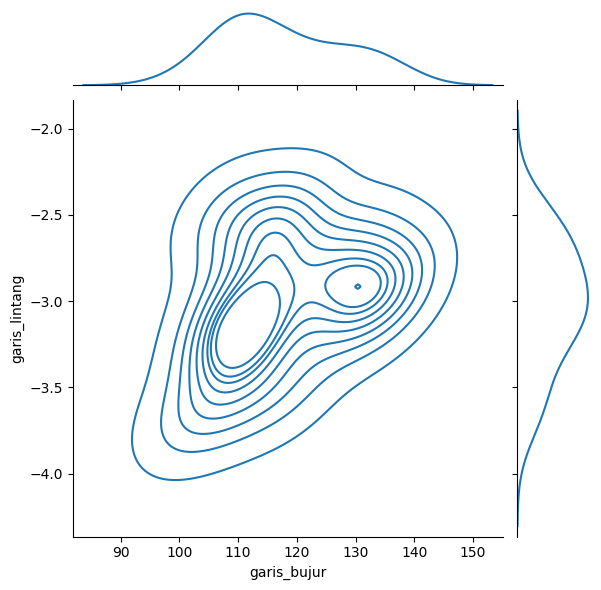

In [ ]:
sns.jointplot(data = mag_pred2b[mag_pred2b['yhat2']>3.0], x='garis_bujur', y='garis_lintang',  kind="kde")
plt.show()

In [ ]:
mag_pred3=mag_pred2b[['garis_lintang','garis_bujur']][mag_pred2b['yhat2']>3.0]
mag_pred3

,garis_lintang,garis_bujur
194,-3.1,130.9
195,-2.5,118.3
197,-2.9,135.8
198,-2.6,113.8
199,-2.7,117.9
201,-3.3,107.8
202,-2.8,124.7
204,-3.2,111.3
205,-3.0,125.7
208,-3.7,101.1


### Prediksi Lokasi Gempa Bumi > 3.5 SR

In [ ]:
import folium
from folium import plugins
eq_map = folium.Map(location=[5,100],tiles='Stamen Terrain',zoom_start=7.0,min_zoom=2.0)
eq_map.add_child(plugins.HeatMap(mag_pred3))
eq_map

### Prediksi Lokasi Gempa Bumi Terparah pada Tahun 2024

In [ ]:
L2=result3[result3['ds']=='2024-07-20']['L1'].tolist()[0]
L2

'[-3.3, 107.8]'

In [ ]:
L3=L2[1:-1].split(', ')
L4=[[float(L3[0]),float(L3[1])]]
print(L4)

[[-3.3, 107.8]]


In [ ]:
import folium
from folium import plugins
eq_map = folium.Map(location=[5,100],tiles='Stamen Terrain',zoom_start=7.0,min_zoom=2.0)
eq_map.add_child(plugins.HeatMap(L4))
eq_map